In [1]:
from scipy.io import wavfile
from scipy.signal import butter, filtfilt
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, widgets,fixed, interact_manual
from scipy.signal import hilbert,decimate

In [2]:
### Loading data
eegData = np.load('kh9_1_sEEG.npy')
words = np.load('kh9_1_words.npy')
audio = np.load('kh9_1_audio.npy')
#Downsample the audio a bit
audio = decimate(audio,8)
electrodeNames = np.load('kh9_1_channelNames.npy')
sr=1024

In [3]:
electrodeNames[103]

array(['RT14'], dtype='<U5')

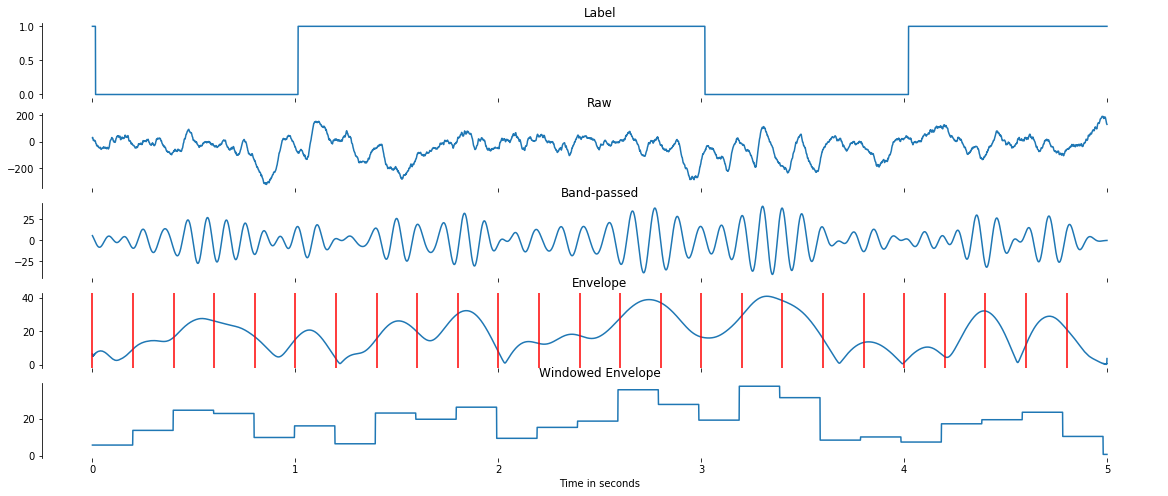

In [5]:
### Visualizing raw data
### Here, we inspect the raw data and the corresponding labels
### and see if certain frequency ranges contain obvious information
### or artifacts

# Theta = 4-7 Hz
# Alpha = 8-12
# Beta = 12-30
# Gamma = 30-50
# High-Gamma = 60-90
lowFrequencyCutoff=8
highFrequencyCutoff=12
#Start and end (in seconds) of the eeg bit
start=11
end=16
x=np.arange(start*sr,end*sr)/sr-start
#Creating a butterworth filter
nyquist = sr/2
b, a = butter(3, [lowFrequencyCutoff/nyquist,highFrequencyCutoff/nyquist], btype='bp')
# Cutting out the corresponding data
selectedChannel = 103
dat = eegData[sr*start:sr*end,selectedChannel]
# Initializing the plot
fig, ax = plt.subplots(5,figsize=[20,8],sharex=True)
# Plotting the words binarized (1 if a word is spoken, 0 else)
ax[0].set_title('Label')
lbl = words[sr*start:sr*end]!=''
ax[0].plot(x,lbl,label='Words')
# Plotting the raw data
ax[1].set_title('Raw')
ax[1].plot(x,dat,label='Raw')
# Bandpass filtering and plotting
filtered=filtfilt(b,a,dat)
ax[2].set_title('Band-passed')
ax[2].plot(x,filtered,label='Band-passed')
# Calculating the hilbert envelope of the filtered signal
hilEnv=np.abs(hilbert(filtered))
ax[3].set_title('Envelope')
ax[3].plot(x,hilEnv,label='Band-passed')
# Windowing
winLength = 0.2
for i in np.arange(np.min(x),np.max(x),winLength):
    ax[3].axvline(x=i,color='r')
winEnv=hilEnv
for win in range(0,len(hilEnv),int(winLength*sr)):
    winEnv[win:win+int(winLength*sr)]=np.mean(hilEnv[win:win+int(winLength*sr)])
ax[4].set_title('Windowed Envelope')
ax[4].plot(x,winEnv,label='Windowed Envelope')
ax[4].set_xlabel('Time in seconds')

#Making it a bit prettier
for axs in ax:
    axs.spines['right'].set_visible(False)
    axs.spines['top'].set_visible(False)
    axs.spines['bottom'].set_visible(False)
plt.show()


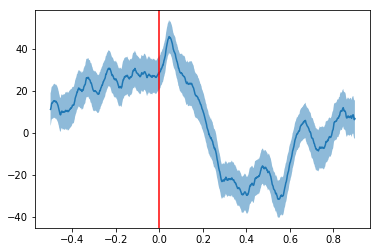

In [174]:
### Plotting ERPs
### Find all positions where a word starts and plot the average signal
### This is not super informative for speech data
wordStarts = np.where(np.diff(words!='')>0)[0]
selectedChannel = 103
dat = eegData[:,selectedChannel]
## Filter the data beforehand and apply the envelope
## This bit can be uncommented if data should be filtered
#lowFrequencyCutoff=60
#highFrequencyCutoff=90
#b, a = butter(3, [lowFrequencyCutoff/sr/2,highFrequencyCutoff/sr/2], btype='bp')
#filtered=filtfilt(b,a,dat)
#filtered=np.abs(hilbert(filtered))
#dat=filtered
# Plot 500ms before word start and 1000ms after
before = int(0.5*sr)
after = int(0.9*sr)
trials = np.zeros((before+after,np.shape(wordStarts)[0]))
#Collect all wordStarts
for i, start in enumerate(wordStarts):
    trials[:,i]=dat[start-before:start+after]
# Calculate the ERP as the mean of all trials
erp = np.mean(trials, axis=1)
# And the standard error as the standard deviation devided by the sqrt(number of trials)
erpSTE = np.std(trials, axis=1)/np.sqrt(np.shape(wordStarts)[0])
#Plotting
fig,ax = plt.subplots()
x=np.arange(-before,after)/sr
ax.plot(x,erp)
plt.fill_between(x, erp-erpSTE, erp+erpSTE,alpha=0.5)
ax.axvline(x=0,color='r')
plt.show()

### Note
These get particularly interesting if different conditions can be compared with each other

### Fourier Transform
* **Time Domain:**  Shows how a signal changes over time.
* **Frequency Domain:** Shows how much of the signal lies within each given frequency band over a range of frequencies

* **Fourier Transform:** Tranforms Time domain representation into a frequency domain representation 

Text(0.5, 0, 'Frequency')

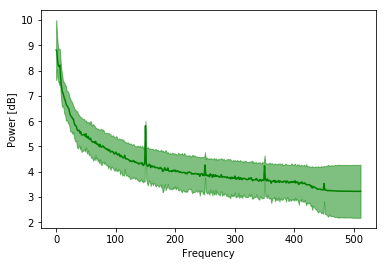

In [164]:
### Plottint the spectrum during all trials
### Find all positions where a word starts and plot the average signal
wordStarts = np.where(np.diff(words!='')>0)[0]
selectedChannel = 103
# We want 800 ms of data
duration = int(0.8*sr)
freqs = np.fft.rfftfreq(duration, d=1/sr)  
trialPower = np.zeros((freqs.shape[0],np.shape(wordStarts)[0]))
#Collect all wordStarts
for i, start in enumerate(wordStarts):
    trial = eegData[start:start+duration,selectedChannel]
    trial = trial
    freqPower=np.log10(np.abs(np.fft.rfft(trial))**2)
    trialPower[:,i]=freqPower
avgPower = np.mean(trialPower,axis=1)
powerSTD = np.std(trialPower,axis=1)
plt.plot(freqs,avgPower,color='green')
plt.fill_between(freqs, avgPower-powerSTD, avgPower+powerSTD,color='green',alpha=0.5)
plt.ylabel('Power [dB]')
plt.xlabel('Frequency')
#

### Note
Of course, different conditions can be compared here, too.

### Short Time Fourier Transform
* Allows to see distribution of frequency components over time
* Determining factors:
    * Window length
    * Sampling Rate
* Window length is tradeoff between temporal and frequency resolution
    * $\frac{WindowLength}{2} = |Frequency Bins|$
    * $\frac{Nyquist Frequency}{ |Frequency Bins| }$ = Width of each fequency bin

In [21]:
# This function plots the raw data and the corresponding spectrogram
def plotRawSpec(data,sr,start=5,duration=5,winLength=0.05):
    e=start+duration
    x=np.arange(start*sr,sr*e)/sr-start
    fig, ax = plt.subplots(2,figsize=[20,4])
    dat = data[sr*start:sr*e]
    # Plotting the raw data
    ax[0].set_title('Raw')
    ax[0].plot(x,dat,label='Raw')
    # Adding the lines for the end and start of each window in which spectra are calculated
    for i in np.arange(np.min(x),np.max(x),winLength):
        ax[0].axvline(x=i,color='r')
    ax[0].set_xlim(0,x[-1])
    numWindows=int(np.floor((dat.shape[0])/(winLength*sr)))
    numSpecs=int(np.floor(winLength*sr / 2 + 1))
    spec=np.zeros((numWindows,numSpecs))
    freqs = np.fft.rfftfreq(int(winLength*sr), d=1/sr)
    # Calculate spectrum for each window
    for w in range(numWindows):
        s=int(w*winLength*sr)
        e=int(s+winLength*sr)
        spec[w,:]=np.abs(np.fft.rfft(dat[s:e]))**2  
    ax[1].set_title('Spectrogram')
    spec=np.log10(spec)
    ax[1].imshow(np.flipud(spec.T), aspect='auto', cmap='viridis')
    ax[1].set_xlabel('Spectrogram Number')
    ax[1].set_ylabel(str(len(freqs)) + ' Freqs')
    ax[1].set_yticks([0,spec.shape[1]])
    ax[1].set_yticklabels([str(sr/2),str(0),])
    for axs in ax:
        axs.spines['right'].set_visible(False)
        axs.spines['top'].set_visible(False)
        axs.spines['bottom'].set_visible(False)
    plt.show()

In [22]:

interact(plotRawSpec,data=fixed(eegData[:,0]),sr=fixed(sr),duration=fixed(1),winLength=(0.01,0.11,0.01));

interactive(children=(IntSlider(value=5, description='start', max=15, min=-5), FloatSlider(value=0.05, descrip…

In [23]:
### For comparison on audio data
interact(plotRawSpec,data=fixed(audio),sr=fixed(8000),duration=fixed(1),winLength=(0.01,0.11,0.01));

interactive(children=(IntSlider(value=5, description='start', max=15, min=-5), FloatSlider(value=0.05, descrip…

### Note
For all frequency analyses, it's often interesting to only consider specific parts of the frequency range. For example, only up to 60 Hz.